# DAY-AHEAD CONDITIONAL LINEAR MODEL

## 2025 ENTSO-E data BZN|NL

Residual load x price correlation depending on hour, season and market regime

In [ ]:
#Load data from baseline models

%store -r price_load
%store -r morning_price_load
%store -r afternoon_price_load
%store -r night_price_load
%store -r spring_price_load
%store -r summer_price_load
%store -r autumn_price_load
%store -r winter_price_load

price_load

In [22]:
import pandas as pd
import statsmodels.formula.api as smf
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def month_to_season(m):
    if m in [12, 1, 2]:
        return "winter"
    elif m in [3, 4, 5]:
        return "spring"
    elif m in [6, 7, 8]:
        return "summer"
    else:
        return "autumn"

price_load["season"] = price_load["Month"].apply(month_to_season)

price_load = price_load.rename(columns={
    "Residual load day-ahead (MW)": "residual_load",
    "Price": "price"
})

price_load["hour"] = price_load["Hour"].astype("category")
price_load["season"] = price_load["season"].astype("category")

model = smf.ols(
    formula="""
    price ~ residual_load
          + C(hour)
          + C(season)
          + residual_load:C(season)
    """,
    data=price_load
).fit()

In [100]:
#Testing block: compare my prediction model outcome for January 2025 against observed data in January 2026

#NEXT: GET DAY-AHEAD RESIDUAL LOAD FOR JAN 2026 ENTSO-E, FEED THE MODEL, COMPARE WITH OSBERVED PRICES

repo_root = Path("..").resolve()
sys.path.append(str(repo_root))

#Load 2026 ENTSO-E data
from Source.load_data import load_2026

df_market = load_2026()
df_market = df_market.T.drop_duplicates().T

mtu = df_market['MTU (CET/CEST)'].iloc[:,0]
df_market['Time'] = mtu.str.split(' - ').str[0]
df_market['Time'] = df_market['Time'].str.replace(r"\s*\(.*\)", "", regex=True).str.strip()
df_market['Time'] = pd.to_datetime(df_market['Time'], dayfirst=True)

df_market['Hour'] = df_market['Time'].dt.hour
df_market['Day'] = df_market['Time'].dt.day
df_market['Month'] = df_market['Time'].dt.month

df_market.head()
cols = [
    'Day-ahead Total Load Forecast (MW)',
    'Day-ahead offshore wind (MW)',
    'Day-ahead onshore wind (MW)',
    'Day-ahead solar (MW)',
    'Actual Total Load (MW)',
    'Actual offshore wind (MW)',
    'Actual onshore wind (MW)',
    'Actual solar (MW)'
]

df_market[cols] = df_market[cols].apply(
    pd.to_numeric,
    errors='coerce'
)

residual_load_da = df_market['Day-ahead Total Load Forecast (MW)'] - df_market['Day-ahead offshore wind (MW)'] - df_market['Day-ahead onshore wind (MW)'] - df_market['Day-ahead solar (MW)']
residual_load_actual = df_market['Actual Total Load (MW)'] - df_market['Actual offshore wind (MW)'] - df_market['Actual onshore wind (MW)'] - df_market['Actual solar (MW)']

price_load_2026 = pd.DataFrame({'Residual load actual (MW)':residual_load_actual,'Residual load day-ahead (MW)':residual_load_da,'Price': df_market['Day-ahead Price (EUR/MWh)']})
price_load_2026['Month'] = df_market['Month']
price_load_2026['Hour'] = df_market['Hour']

price_load_2026.head()
price_load_2026 = price_load_2026.rename(columns={
    "Residual load day-ahead (MW)": "residual_load",
    "Hour": "hour",
    "Month": "month",
    "Price": "price"  # optional, for evaluation
})

def month_to_season(m):
    if m in [12, 1, 2]:
        return "winter"
    elif m in [3, 4, 5]:
        return "spring"
    elif m in [6, 7, 8]:
        return "summer"
    else:
        return "autumn"

price_load_2026["season"] = price_load_2026["month"].apply(month_to_season)

#Feed the model

pred_2026 = model.get_prediction(price_load_2026)
pred_df_2026 = pred_2026.summary_frame(alpha=0.1)

price_load_2026["price_hat"] = pred_df_2026["mean"]
price_load_2026["price_lo"] = pred_df_2026["mean_ci_lower"]
price_load_2026["price_hi"] = pred_df_2026["mean_ci_upper"]

price_load_jan2026 = price_load_2026[price_load_2026['month'] == 1]

price_load_jan2026.loc[:, 'price'] = pd.to_numeric(price_load_jan2026['price'], errors='coerce')
print(price_load_jan2026.head())


   Residual load actual (MW)  residual_load  price  month  hour  season  \
0                    6878.10        7134.07  72.91      1     0  winter   
1                    6572.63        7087.09  69.16      1     0  winter   
2                    6460.86        7025.81   59.8      1     0  winter   
3                    6349.68        7116.41   51.9      1     0  winter   
4                    6187.77        7019.76  75.66      1     1  winter   

   price_hat   price_lo   price_hi  
0  55.545337  53.817311  57.273363  
1  54.984022  53.248394  56.719650  
2  54.251851  52.506207  55.997495  
3  55.334336  53.603460  57.065212  
4  52.678507  50.945693  54.411321  


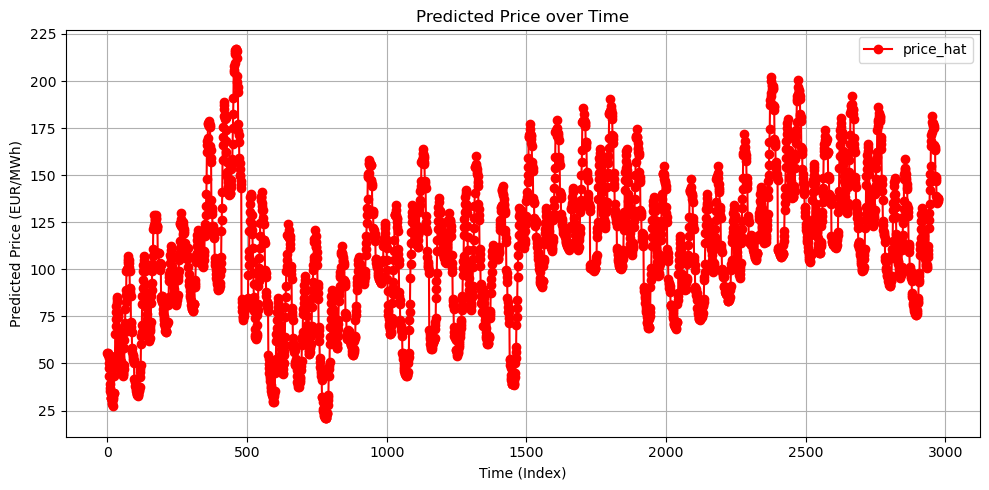

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(price_load_jan2026.index, price_load_jan2026['price_hat'], color='red', marker='o', label='price_hat')

plt.xlabel('Time (Index)')
plt.ylabel('Predicted Price (EUR/MWh)')
plt.title('Predicted Price over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

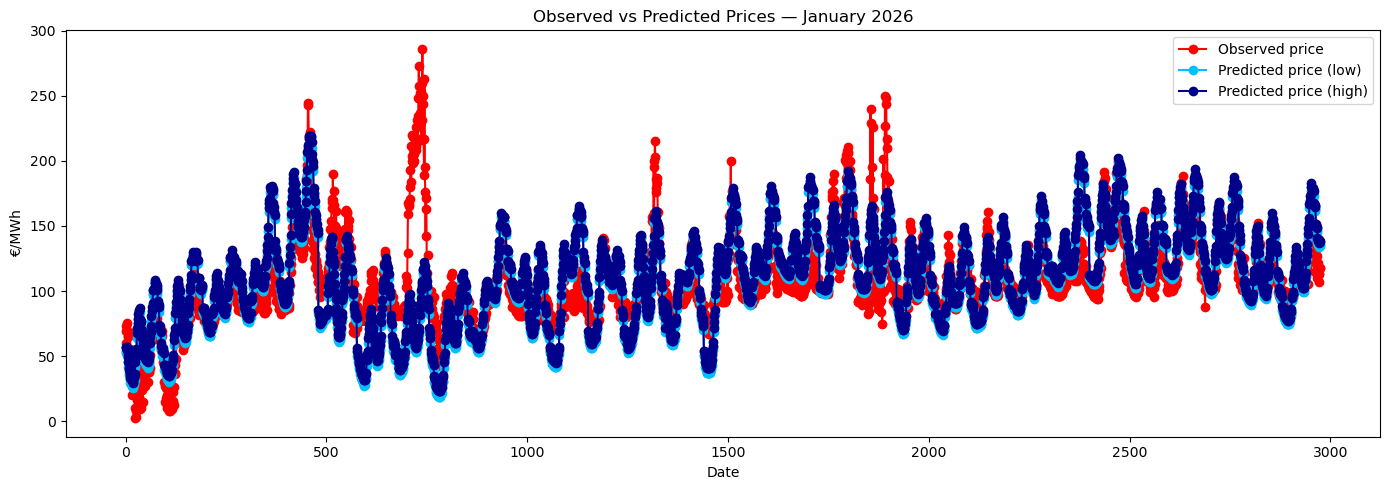

In [101]:
plt.figure(figsize=(14,5))
plt.plot(price_load_jan2026.index, price_load_jan2026["price"],color='red', marker='o', label="Observed price")
plt.plot(price_load_jan2026.index, price_load_jan2026["price_lo"],color='deepskyblue', marker='o', label="Predicted price (low)")
plt.plot(price_load_jan2026.index, price_load_jan2026["price_hi"],color='darkblue', marker='o', label="Predicted price (high)")
plt.xlabel("Date")
plt.ylabel("€/MWh")
plt.title("Observed vs Predicted Prices — January 2026")
plt.legend()
plt.tight_layout()
plt.show()